### Importação das Bibliotecas

In [1]:
# Tratamento dos dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

# Ciência de Dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Biblioteca do Prophet - Modelo de Projeção
from prophet import Prophet
from prophet.plot import plot, plot_plotly, plot_components_plotly, add_changepoints_to_plot
from prophet.plot import add_changepoints_to_plot, plot_seasonality, plot_cross_validation_metric
from prophet.diagnostics import cross_validation

### Importação e Descrição dos Dados

Essa é a parte 3 de um projeto que busca prever as vendas de uma padaria francesa, agora através de modelos de Deep Learning.

Para uma melhor compreensão do cenário, caso ainda não tenha acompanhado, recomenda-se ler o notebook ```bakery_sales_data_analysis.ipynb``` que apresenta uma analise exploratória do dados e o notebook ```bakery_sales_forecasting.ipynb``` traz previsões de vendas com modelos de regressão de Machine Learning.

In [2]:
df = pd.read_csv('bakery_sales.csv', index_col=0)

# Update datatypes and data processing
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time

df['Quantity'] = df['Quantity'].apply(lambda x: abs(int(x)))
df['Quantity'] = df['Quantity'].astype(int)

df['unit_price'] = df['unit_price'].str[:-2]
df['unit_price'] = df['unit_price'].str.replace(",",".")
df['unit_price'] = df['unit_price'].astype(float)

df['ticket_number'] = df['ticket_number'].astype(int)

# Cria coluna do total da compra
df['total_bill'] = df['Quantity'] * df['unit_price']

# Como nesse momento não será feita uma análise por produto, a coluna sera dropada
df.rename(columns={'Quantity':'quantity'}, inplace=True)
df_backup = df.copy()
df.drop(columns=['article', 'unit_price'], inplace=True)
df.head()

,date,time,ticket_number,quantity,total_bill
0,2021-01-02,08:38:00,150040,1,0.90
1,2021-01-02,08:38:00,150040,3,3.60
4,2021-01-02,09:14:00,150041,2,2.40
5,2021-01-02,09:14:00,150041,1,1.15
8,2021-01-02,09:25:00,150042,5,6.00


In [3]:
# Agrupa os dados por ticket (nota fiscal)
df_grouped = df.groupby(by=('ticket_number')).agg({'date':'first',
                                                   'time':'first',
                                                   'quantity':'sum',
                                                   'total_bill':'sum'})

df_grouped.reset_index(inplace=True)

df_grouped.head()

,ticket_number,date,time,quantity,total_bill
0,150040,2021-01-02,08:38:00,4,4.50
1,150041,2021-01-02,09:14:00,3,3.55
2,150042,2021-01-02,09:25:00,5,6.00
3,150043,2021-01-02,09:25:00,5,5.10
4,150044,2021-01-02,09:27:00,1,1.05


In [4]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136451 entries, 0 to 136450
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ticket_number  136451 non-null  int32         
 1   date           136451 non-null  datetime64[ns]
 2   time           136451 non-null  object        
 3   quantity       136451 non-null  int32         
 4   total_bill     136451 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 4.2+ MB


#### Novas Features

In [5]:
# Novas Variaves, para analise
df = df_grouped.copy()

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['day_week'] = df.date.dt.day_of_week
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# Cria um dataset com dados diarios
df_daily = df_grouped[['date', 'quantity', 'total_bill']].groupby('date').sum().reset_index()

df_daily['year'] = df_daily.date.dt.year
df_daily['month'] = df_daily.date.dt.month
df_daily['day'] = df_daily.date.dt.day
df_daily['day_week'] = df_daily.date.dt.day_of_week
df_daily['day_of_year'] = df_daily.date.dt.dayofyear

df_daily.rename(columns={'total_bill':'sales'}, inplace=True)
df_daily.head()

,date,quantity,sales,year,month,day,day_week,day_of_year
0,2021-01-02,581,987.85,2021,1,2,5,2
1,2021-01-03,566,1016.10,2021,1,3,6,3
2,2021-01-04,315,461.90,2021,1,4,0,4
3,2021-01-05,315,536.50,2021,1,5,1,5
4,2021-01-07,310,544.00,2021,1,7,3,7


In [6]:
df_daily.shape

(600, 8)

In [94]:
# Cria função que calcula o MAPE
def calculate_mape(y_true, y_pred):
    """
    Calcula Mean Absolute Percentage Error (MAPE) - Erro Percentual Absoluto Médio.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Avoid division by zero
    mask = y_true != 0
    mask_nan = pd.notna(y_true)
    y_true, y_pred = y_true[mask_nan], y_pred[mask_nan]

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return round(mape, 2)

## Previsão com Deep Learning

### Organizando os dados

⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️ Inserir descrição

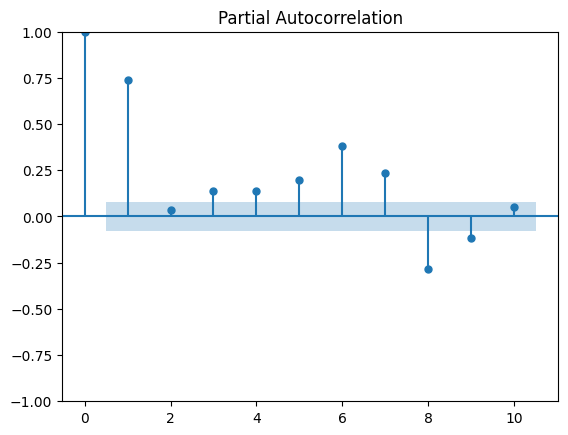

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

# Determinando quantas lags utilizar
plot_pacf(df_daily['sales'], lags=10)
plt.show()

In [8]:
data = df_daily[['date', 'sales']].copy()
data['lag_1'] = data['sales'].shift(1)
data.head()

,date,sales,lag_1
0,2021-01-02,987.85,NaN
1,2021-01-03,1016.10,987.85
2,2021-01-04,461.90,1016.10
3,2021-01-05,536.50,461.90
4,2021-01-07,544.00,536.50


### Modelo 1 - Autoregressivo

In [9]:
date_plot = data.loc[1:,'date']
X_data = data.loc[1:,'lag_1']
y_data = data.loc[1:,'sales']

# Separa os dados em treino e teste
# utiliza os últimos 'day_to_test' dias de teste
day_to_test = 40
X_train = X_data[:-day_to_test]
y_train = y_data[:-day_to_test]

X_test = X_data[-day_to_test:]
y_test = y_data[-day_to_test:]


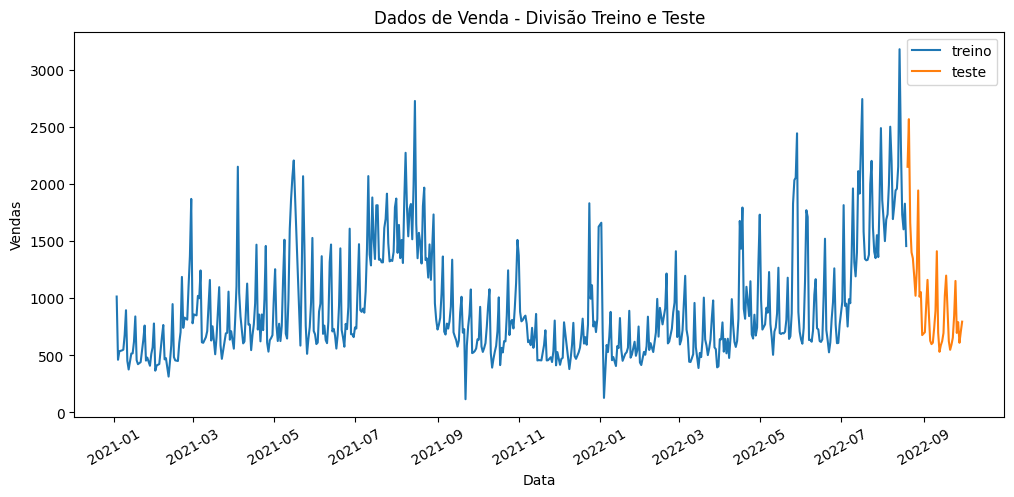

In [10]:
plt.figure(figsize=(12,5))
sns.lineplot(data=data[1:-day_to_test], x='date', y='sales', label='treino')
sns.lineplot(data=data[-day_to_test:], x='date', y='sales', label='teste')
plt.title('Dados de Venda - Divisão Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.xticks(rotation=30)
plt.show()

#### Dados scaled

In [11]:
# Cria scaler com fit apenas nos dados de treino
scaler = StandardScaler()
scaler.fit(X_train.values.reshape(-1,1))

# Aplica transform em todos os dados
X_train_sc = scaler.transform(X_train.values.reshape(-1,1))
y_train_sc = scaler.transform(y_train.values.reshape(-1,1))
X_test_sc = scaler.transform(X_test.values.reshape(-1,1))
y_test_sc = scaler.transform(y_test.values.reshape(-1,1))

In [12]:
X_train_sc = X_train_sc.reshape((X_train_sc.shape[0], X_train_sc.shape[1], 1))
X_test_sc = X_test_sc.reshape((X_test_sc.shape[0], X_test_sc.shape[1], 1))

#### Criando o modelo - RNN - Rede Neural Recorrente

In [13]:
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [14]:
# Define os parametros do modelo
model = Sequential()

model.add(LSTM(128, input_shape=(X_train_sc.shape[1], X_train_sc.shape[2])))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='RMSProp')

c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# model.summary()

In [16]:
resultado = model.fit(X_train_sc, y_train_sc,  epochs=100) #validation_data=(X_test_sc, y_test_sc),

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7924
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7576 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6112 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5584 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4995 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4449 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4263 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4695 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4334 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4196 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4546 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4403 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4292 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3954 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [17]:
y_pred_train = model.predict(X_train_sc)
y_pred_test = model.predict(X_test_sc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[]

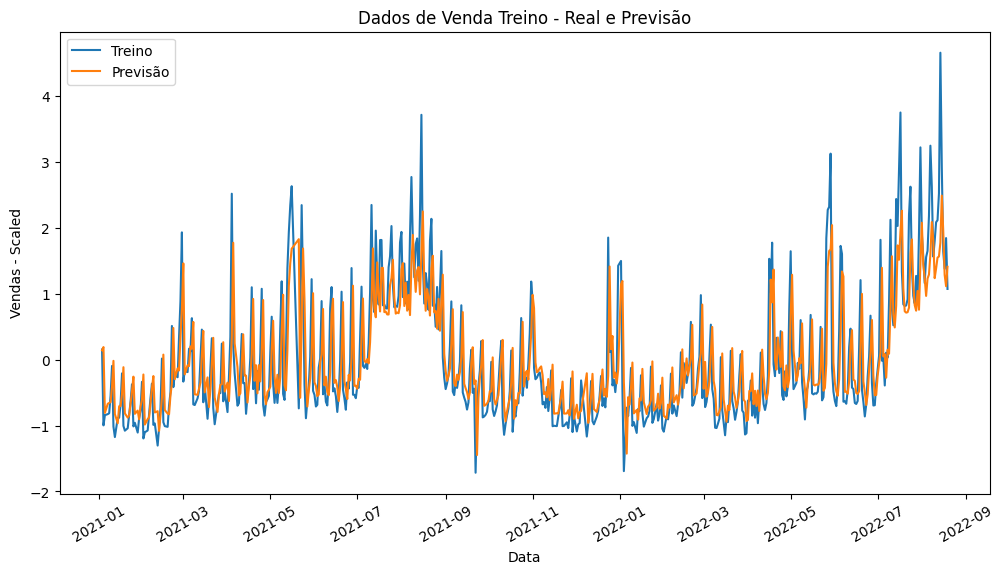

In [40]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily[1:-day_to_test], x='date', y=y_train_sc[:,0], label='Treino')
sns.lineplot(data=df_daily[1:-day_to_test], x='date', y=y_pred_train[:,0], label='Previsão')
plt.title('Dados de Venda Treino - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()

MAPE: 253.84


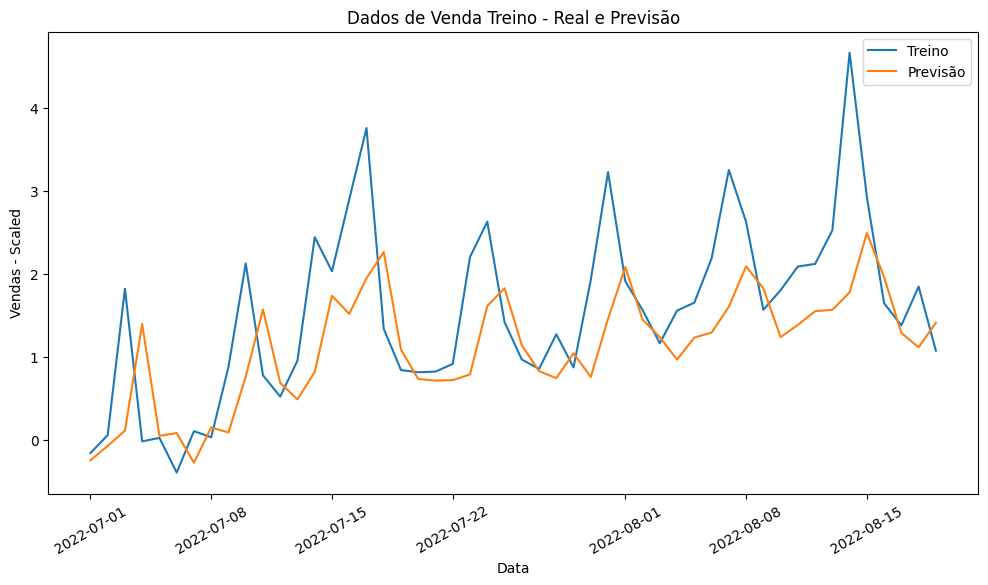

In [34]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily[(-50-day_to_test):-day_to_test], x='date', y=y_train_sc[-50:,0], label='Treino')
sns.lineplot(data=df_daily[(-50-day_to_test):-day_to_test], x='date', y=y_pred_train[-50:,0], label='Previsão')
plt.title('Dados de Venda Treino - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()

print('MAPE:', calculate_mape(y_train_sc[-50:,0], y_pred_train[-50:,0]))

MAPE: 172.49


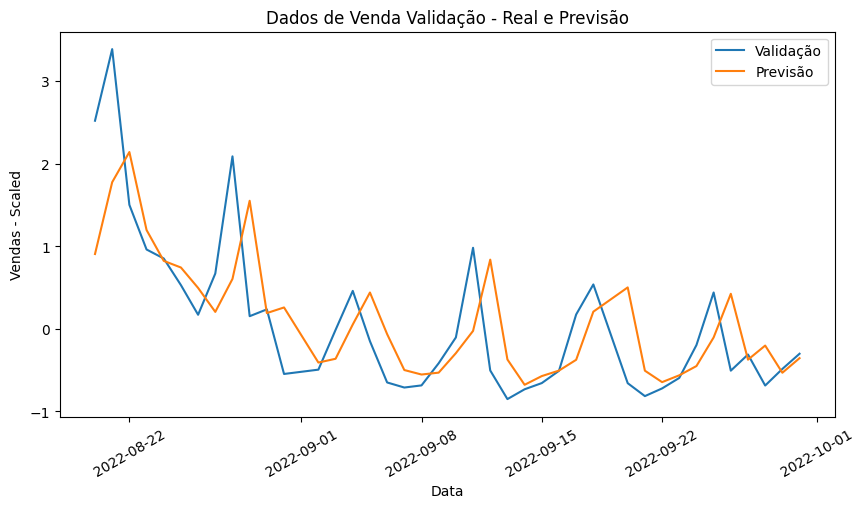

In [33]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_daily[-day_to_test:], x='date', y=y_test_sc[:,0], label='Validação')
sns.lineplot(data=df_daily[-day_to_test:], x='date', y=y_pred_test[:,0], label='Previsão')
plt.title('Dados de Venda Validação - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()

print('MAPE:', calculate_mape(y_test_sc[:,0], y_pred_test[:,0]))

### Modelo 2 - Adicionando features

In [41]:
data2 = df_daily[['date', 'month', 'day_week', 'day_of_year', 'sales']].copy()
data2['lag_1'] = data2['sales'].shift(1)
data2.head()

,date,month,day_week,day_of_year,sales,lag_1
0,2021-01-02,1,5,2,987.85,NaN
1,2021-01-03,1,6,3,1016.10,987.85
2,2021-01-04,1,0,4,461.90,1016.10
3,2021-01-05,1,1,5,536.50,461.90
4,2021-01-07,1,3,7,544.00,536.50


In [48]:
# Extrai as datas, features e target
date_plot = data.loc[1:,'date']
X_data2 = data2.loc[1:].drop(columns=['date','sales'])
y_data2 = data2.loc[1:,'sales']

# Separa os dados em treino e teste
# utiliza os últimos 'day_to_test2' dias de teste
day_to_test2 = 40
X_train2 = X_data2[:-day_to_test2]
y_train2 = y_data2[:-day_to_test2]

X_test2 = X_data2[-day_to_test2:]
y_test2 = y_data2[-day_to_test2:]

In [54]:
# Cria scaler com fit apenas nos dados de treino
scaler2 = StandardScaler()
scaler2.fit(X_train2)

scaler2y = StandardScaler()
scaler2y.fit(y_train2.values.reshape(-1,1))

# Aplica transform em todos os dados
X_train_sc2 = scaler2.transform(X_train2)
X_test_sc2 = scaler2.transform(X_test2)

y_train_sc2 = scaler2y.transform(y_train2.values.reshape(-1,1))
y_test_sc2 = scaler2y.transform(y_test2.values.reshape(-1,1))

In [56]:
X_train_sc2 = X_train_sc2.reshape((X_train_sc2.shape[0], X_train_sc2.shape[1], 1))
X_test_sc2 = X_test_sc2.reshape((X_test_sc2.shape[0], X_test_sc2.shape[1], 1))

#### Criando o modelo

In [57]:
# Define os parametros do modelo
model2 = Sequential()

model2.add(LSTM(128, input_shape=(X_train_sc2.shape[1], X_train_sc2.shape[2])))
model2.add(Dense(units=1))

model2.compile(loss='mean_squared_error', optimizer='RMSProp')

c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
resultado2 = model2.fit(X_train_sc2, y_train_sc2, validation_data=(X_test_sc2, y_test_sc2),  epochs=150) #validation_data=(X_test_sc, y_test_sc),

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.9226 - val_loss: 0.7700
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7970 - val_loss: 0.6611
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6093 - val_loss: 0.5885
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5587 - val_loss: 0.5091
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4627 - val_loss: 0.4418
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4051 - val_loss: 0.4320
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3307 - val_loss: 0.3752
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2979 - val_loss: 0.3459
Epoch 9/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2701 - val_loss: 0.3087
Epoch 10/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2792 - val_loss: 0.2613
Epoch 11/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2222 - val_loss: 0.3367
Epoch 12/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0

In [61]:
y_pred_train2 = model.predict(X_train_sc2)
y_pred_test2 = model.predict(X_test_sc2)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[]

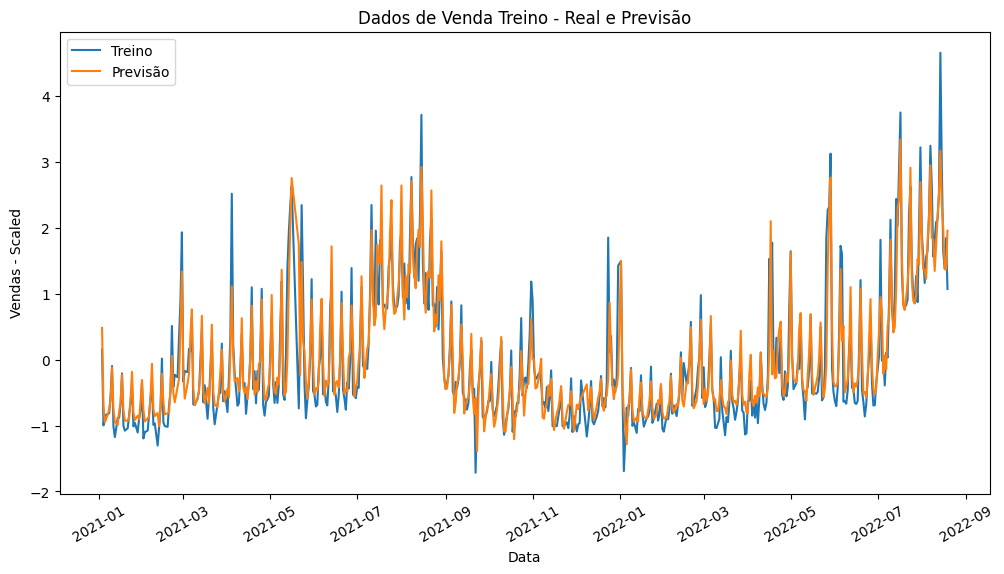

In [62]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily[1:-day_to_test], x='date', y=y_train_sc2[:,0], label='Treino')
sns.lineplot(data=df_daily[1:-day_to_test], x='date', y=y_pred_train2[:,0], label='Previsão')
plt.title('Dados de Venda Treino - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()

MAPE Modelo: 180.17 %
MAPE Problema: 16.23 %


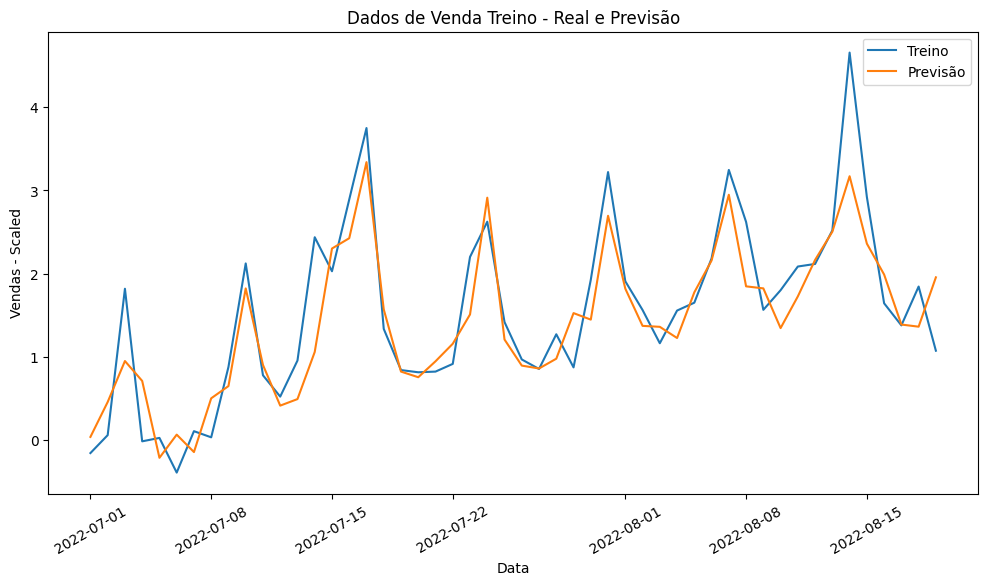

In [116]:
# Dados dos últimos 50 dias de treino
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily[(-50-day_to_test):-day_to_test], x='date', y=y_train_sc2[-50:,0], label='Treino')
sns.lineplot(data=df_daily[(-50-day_to_test):-day_to_test], x='date', y=y_pred_train2[-50:,0], label='Previsão')
plt.title('Dados de Venda Treino - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()

print('MAPE Modelo:', calculate_mape(y_train_sc2[-50:,0], y_pred_train2[-50:,0]), '%')
print('MAPE Problema:', calculate_mape(scaler2y.inverse_transform(y_train_sc2)[:,0], scaler2y.inverse_transform(y_pred_train2)[:,0]), '%')

MAPE Modelo: 91.79 %
MAPE Problema: 12.76 %


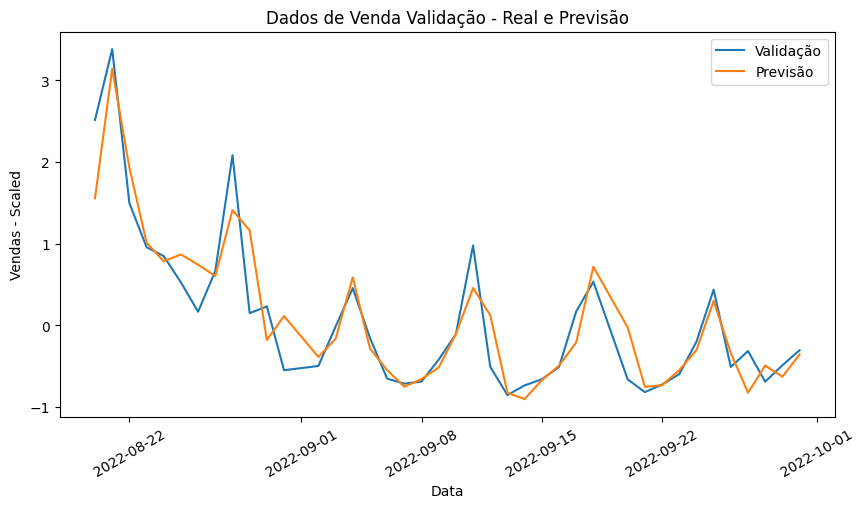

In [115]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_daily[-day_to_test:], x='date', y=y_test_sc2[:,0], label='Validação')
sns.lineplot(data=df_daily[-day_to_test:], x='date', y=y_pred_test2[:,0], label='Previsão')
plt.title('Dados de Venda Validação - Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Vendas - Scaled')
plt.xticks(rotation=30)
plt.plot()

print('MAPE Modelo:', calculate_mape(y_test_sc2[:,0], y_pred_test2[:,0]), '%')
print('MAPE Problema:', calculate_mape(scaler2y.inverse_transform(y_test_sc2)[:,0], scaler2y.inverse_transform(y_pred_test2)[:,0]), '%')

In [113]:
df_result = pd.DataFrame(data={'date': df_daily[-day_to_test:]['date'],
                                'real':scaler2y.inverse_transform(y_test_sc2)[:,0], 
                               'predict':scaler2y.inverse_transform(y_pred_test2)[:,0]})
df_result.reset_index(drop=True, inplace=True)
df_result['dif'] = df_result['predict'] - df_result['real']
df_result['mape'] = abs((df_result['real'] - df_result['predict']) / df_result['real'])*100

df_result['predict'] = df_result.predict.apply(lambda x: round(x, 2))
df_result['dif'] = df_result.dif.apply(lambda x: round(x, 2))
df_result['mape'] = df_result.mape.apply(lambda x: round(x, 2))

df_result.tail()

,date,real,predict,dif,mape
35,2022-09-26,697.35,779.22,81.87,11.74
36,2022-09-27,791.55,545.42,-246.13,31.09
37,2022-09-28,610.70,705.91,95.21,15.59
38,2022-09-29,707.40,639.58,-67.82,9.59
39,2022-09-30,795.95,770.99,-24.96,3.14
